# Predicting customer complaints

using GRU

# 1- Import key Modules

In [1]:
# support both Python 2 and Python 3 with minimal overhead.
from __future__ import absolute_import, division, print_function

# I am an engineer. I care only about error not warning. So, let's be maverick and ignore warnings.
import warnings
warnings.filterwarnings('ignore')

In [2]:

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, GRU, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.layers import Dropout
import re
from nltk.corpus import stopwords
from nltk import word_tokenize
STOPWORDS = set(stopwords.words('english'))

Using TensorFlow backend.


In [3]:
# Visualization 
import matplotlib.pyplot as plt
import seaborn as sns
from pprint import pprint
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# 2-Loading and preparing data

In [4]:
df = pd.read_csv('Consumer_Complaints.csv')
#df=df.drop()
df.shape

(1025010, 19)

In [5]:
df.isnull().sum()

Date received                         0
Product                               0
Sub-product                      235170
Issue                                 0
Sub-issue                        496157
Consumer Complaint               747196
Company Public Response          706646
Company                               0
State                             12360
ZIP code                          16718
Tags                             883422
Consumer consent provided?       533099
Submitted via                         0
Date Sent to Company                  0
Company Response to Consumer          3
Timely response?                      0
Consumer disputed?               256456
Complaint ID                          0
Unnamed: 18                     1025010
dtype: int64

In [6]:
df=df.dropna(subset=['Consumer Complaint'])
df.shape

(277814, 19)

In [7]:
# save data
df.to_csv('short_consumer_complaints.csv')

In [8]:
df = pd.read_csv('short_consumer_complaints.csv')
df=df.rename(columns={'Unnamed: 0':'random_columns'})
df.shape

(277814, 20)

### 2.1.Working with target variable

In [9]:
df.Product.value_counts()

Debt collection                                                                 63268
Credit reporting, credit repair services, or other personal consumer reports    49006
Mortgage                                                                        43837
Credit reporting                                                                31593
Credit card                                                                     18842
Student loan                                                                    16689
Bank account or service                                                         14887
Credit card or prepaid card                                                     10659
Consumer Loan                                                                    9474
Checking or savings account                                                      6489
Money transfer, virtual currency, or money service                               3089
Vehicle loan or lease                                 

rename of columns as they mean same somewhat. Hence, our categories will be defined well.

In [10]:
df.loc[df['Product'] == 'Credit reporting', 'Product'] = 'Credit reporting, credit repair services, or other personal consumer reports'
df.loc[df['Product'] == 'Credit card', 'Product'] = 'Credit card or prepaid card'
df.loc[df['Product'] == 'Payday loan', 'Product'] = 'Payday loan, title loan, or personal loan'
df.loc[df['Product'] == 'Virtual currency', 'Product'] = 'Money transfer, virtual currency, or money service'
df = df[df.Product != 'Other financial service']

In [11]:
df.Product.value_counts()

Credit reporting, credit repair services, or other personal consumer reports    80599
Debt collection                                                                 63268
Mortgage                                                                        43837
Credit card or prepaid card                                                     29501
Student loan                                                                    16689
Bank account or service                                                         14887
Consumer Loan                                                                    9474
Checking or savings account                                                      6489
Payday loan, title loan, or personal loan                                        3934
Money transfer, virtual currency, or money service                               3105
Vehicle loan or lease                                                            2791
Money transfers                                       

In [12]:
df.Product.nunique()

13

### 2.2.Text Pre-processing

In [13]:
df.head(2)

,random_columns,Date received,Product,Sub-product,Issue,Sub-issue,Consumer Complaint,Company Public Response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date Sent to Company,Company Response to Consumer,Timely response?,Consumer disputed?,Complaint ID,Unnamed: 18
0,1,10-01-2016,"Credit reporting, credit repair services, or o...",NaN,Incorrect information on credit report,Account status,I have outdated information on my credit repor...,Company has responded to the consumer and the ...,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",AL,352XX,NaN,Consent provided,Web,10-05-2016,Closed with explanation,Yes,No,2141773,NaN
1,2,10/17/2016,Consumer Loan,Vehicle loan,Managing the loan or lease,NaN,I purchased a new car on XXXX XXXX. The car de...,NaN,"CITIZENS FINANCIAL GROUP, INC.",PA,177XX,Older American,Consent provided,Web,10/20/2016,Closed with explanation,Yes,No,2163100,NaN


In [14]:
def print_plot(index):
    example = df[df.index == index][['Consumer Complaint', 'Product']].values[0]
    if len(example) > 0:
        print(example[0])
        print('Product:', example[1])
print_plot(10)

Without provocation, I received notice that my credit line was being decreased by nearly 100 %. My available credit was reduced from $ XXXX to XXXX ( the rough amount of my available balance ). 

When I called to question the change, I was provided a nob-descript response referencing my XXXX report. It was my understanding that under the FCRA I was entitled to a copy of this report, but was refused by Citi and have been given no further explanation. 

This is predatory in that it affects my utilization of credit, further subjecting me to increase in APrs, etc and a higher cost of credit without any reason.
Product: Credit card or prepaid card


In [15]:
print_plot(100)

Equifax is refusing to remove the CH XXXX bankruptcy from my credit file. I filed back in XXXX XXXX so the public record should have been removed on XXXX XXXX. I called them last week and I was told that they would not remove it and would stay on my file until XXXX XXXX.
Product: Credit reporting, credit repair services, or other personal consumer reports


### 2.3.Cleaning

In [16]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
    text = BAD_SYMBOLS_RE.sub('', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing. 
    text = text.replace('x', '')
#    text = re.sub(r'\W+', '', text)
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwors from text
    return text
df['Consumer Complaint'] = df['Consumer Complaint'].apply(clean_text)
df['Consumer Complaint'] = df['Consumer Complaint'].str.replace('\d+', '')


In [17]:
print_plot(10)

without provocation received notice credit line decreased nearly  available credit reduced rough amount available balance called question change provided nobdescript response referencing report understanding fcra entitled copy report refused citi given eplanation predatory affects utilization credit subjecting increase aprs etc higher cost credit without reason
Product: Credit card or prepaid card


# 3- Prepare Data for Model

- Vectorize consumer complaints text, by turning each text into either a sequence of integers or into a vector.
- Limit the data set to the top 5,0000 words.
- Set the max number of words in each complaint at 250.

In [18]:
# Max number of words in each complaint.
sent_length=250 

tokenizer = Tokenizer(num_words=sent_length, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['Consumer Complaint'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 121550 unique tokens.


### 3.1.Truncate and pad
Truncate and pad the input sequences so that they are all in the same length for modeling.**

In [19]:
X = tokenizer.texts_to_sequences(df['Consumer Complaint'].values)
X = pad_sequences(X, maxlen=sent_length)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (277521, 250)


### 3.2. Encoding target variable

Converting categorical labels to numbers

In [20]:
Y = pd.get_dummies(df['Product']).values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (277521, 13)


### 3.3.Train test split.

In [21]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.10, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(249768, 250) (249768, 13)
(27753, 250) (27753, 13)


# 4- GRU Neural Network

- The first layer is the embedded layer that uses 100 length vectors to represent each word.
- SpatialDropout1D performs variational dropout in NLP models.
- The next layer is the LSTM layer with 100 memory units.
- The output layer must create 13 output values, one for each class.
- Activation function is softmax for multi-class classification.
- Because it is a multi-class classification problem, categorical_crossentropy is used as the loss function.

### 4.1.Define parameters

In [22]:
# The maximum number of words to be used. (most frequent/top words)
voc_size = 5000 # this is same as size of our vocabulary
# Max number of words in each sentence.
sent_length=250 # after padding
embedding_vector_features=100 # dimension of embedding layer
epochs=5
batch_size=64
# for our padding seq
input_length=X.shape[1] # same as sent_length
uniq_y_label=df['Product'].nunique() # this will be dimension of our output layer i.e 13

In [23]:
model = Sequential()
model.add(Embedding(voc_size, embedding_vector_features, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(GRU(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(uniq_y_label, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [24]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 250, 100)          500000    
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 250, 100)          0         
_________________________________________________________________
gru_1 (GRU)                  (None, 100)               60300     
_________________________________________________________________
dense_1 (Dense)              (None, 13)                1313      
Total params: 561,613
Trainable params: 561,613
Non-trainable params: 0
_________________________________________________________________


##### computing values in summary

### 4.2.Train the model

In [25]:
from tensorflow.keras.layers import Dropout
from keras.callbacks import EarlyStopping
from sklearn.utils import class_weight

#class_weights = class_weight.compute_class_weight('balanced',
#                                                 np.unique(Y_train),
#                                                 Y_train)

In [27]:
%%time
history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,
                    validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', 
                    patience=3, min_delta=0.0001)])


Train on 224791 samples, validate on 24977 samples
Epoch 1/5
224791/224791 [==============================] - 2058s 9ms/step - loss: 497069385190.1899 - accuracy: 0.5147 - val_loss: 1.4882 - val_accuracy: 0.5211
Epoch 2/5
224791/224791 [==============================] - 12164s 54ms/step - loss: 1.3814 - accuracy: 0.5640 - val_loss: 1.4374 - val_accuracy: 0.5359
Epoch 3/5
224791/224791 [==============================] - 2222s 10ms/step - loss: 5115675.1670 - accuracy: 0.5722 - val_loss: 1.4138 - val_accuracy: 0.5429
Epoch 4/5
224791/224791 [==============================] - 2198s 10ms/step - loss: 1.3081 - accuracy: 0.5782 - val_loss: 1.3979 - val_accuracy: 0.5479
Epoch 5/5
224791/224791 [==============================] - 2244s 10ms/step - loss: 1.2931 - accuracy: 0.5837 - val_loss: 1.3822 - val_accuracy: 0.5531
Wall time: 5h 48min 8s


# 5- Model Evaluation

In [28]:
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

27753/27753 [==============================] - 31s 1ms/step
Test set
  Loss: 1.385
  Accuracy: 0.551


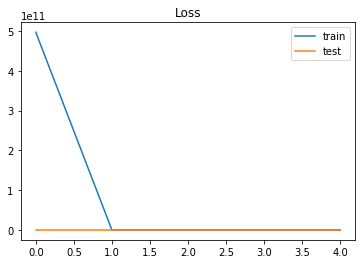

In [29]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

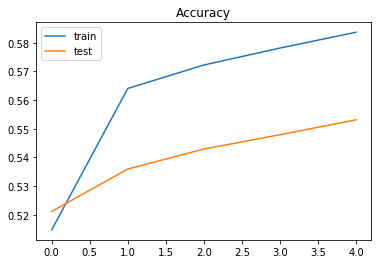

In [31]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show();

# 6- Check on Out-Of-Sample Data

In [32]:
new_complaint = ['I am a victim of identity theft and someone stole my identity and personal information to open up a Visa credit card account with Bank of America. The following Bank of America Visa credit card account do not belong to me : XXXX.']

In [33]:
seq = tokenizer.texts_to_sequences(new_complaint)

In [36]:
padded = pad_sequences(seq, maxlen=sent_length)

In [37]:
pred = model.predict(padded)
pred

array([[1.9635752e-01, 8.3718628e-02, 2.9048263e-03, 6.3318193e-01,
        1.5721211e-02, 9.0108542e-03, 4.7189975e-03, 2.1439989e-03,
        2.0971133e-03, 8.2503690e-04, 4.7838904e-02, 3.2264399e-04,
        1.1584038e-03]], dtype=float32)

In [38]:
np.argmax(pred)

3

In [41]:
# showing what exact class label we used. Give names as given in original data with same name and same sequence

labels = ['Credit reporting, credit repair services, or other personal consumer reports',
          'Debt collection', 'Mortgage', 'Credit card or prepaid card', 'Student loan',
          'Bank account or service', 'Checking or savings account', 'Consumer Loan',
          'Payday loan, title loan, or personal loan', 'Vehicle loan or lease', 
          'Money transfer, virtual currency, or money service', 'Money transfers', 'Prepaid card']

len(labels)

13

In [42]:
# the label that has highest prob. will be shown
labels[np.argmax(pred)]

'Credit card or prepaid card'